In [1]:
from random import randint
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
class KMeansClustering(ClusterMixin, BaseEstimator):
    def __init__(self, k = 3, tolerance = 0.0001, max_iterations = 500):
        self.k = k
        self.tolerance = tolerance
        self.max_iterations = max_iterations

    def fit(self, data):

        self.centroids = {}

        #initialize the centroids, the first 'k' elements in the dataset will be our initial centroids
        for i in range(self.k):
            self.centroids[i] = data[i]

        #begin iterations
        for i in range(self.max_iterations):
            self.classes = {}
            for i in range(self.k):
                self.classes[i] = []

            #find the distance between the point and cluster; choose the nearest centroid
            for features in data:
                distances = [np.linalg.norm(features - self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classes[classification].append(features)

            previous = dict(self.centroids)

            #average the cluster datapoints to re-calculate the centroids
            for classification in self.classes:
                self.centroids[classification] = np.average(self.classes[classification], axis = 0)

            isOptimal = True

            for centroid in self.centroids:

                original_centroid = previous[centroid]
                curr = self.centroids[centroid]

                if np.sum((curr - original_centroid)/original_centroid * 100.0) > self.tolerance:
                    isOptimal = False

            #break out of the main loop if the results are optimal, ie. the centroids don't change their positions much(more than our tolerance)
            if isOptimal:
                break

    def pred(self, data):
        distances = [np.linalg.norm(data - self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

In [3]:
df = pd.read_csv('mnist_784.csv', header=0)
df = df[1:701]
Y = df['class']
X = df.drop(['class'], axis=1)

X = MinMaxScaler().fit_transform(X=X)

pca = PCA(n_components=2)

principal = pca.fit_transform(X)
principal = list(map(list, zip(*principal)))
principal_df = pd.DataFrame(zip(*principal, Y))

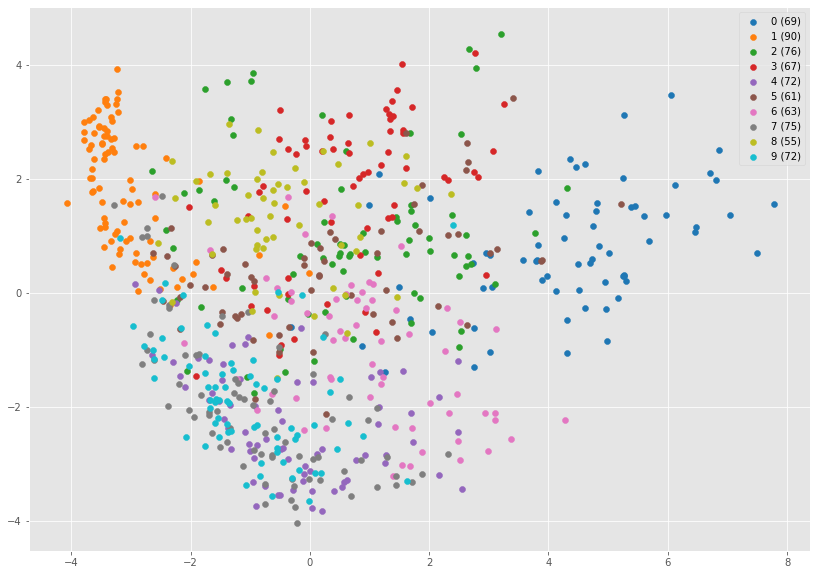

In [8]:
colors = mcolors.TABLEAU_COLORS
labels = range(0, 10)

plt.figure(figsize=(14, 10))

for label, color in zip(labels, colors):
    rows_to_draw = principal_df[2] == label
    plt.scatter(principal_df.loc[rows_to_draw, 0],
                principal_df.loc[rows_to_draw, 1],
                c=color,
                label=f'{label} ({rows_to_draw.sum()})')

plt.legend()
plt.show()

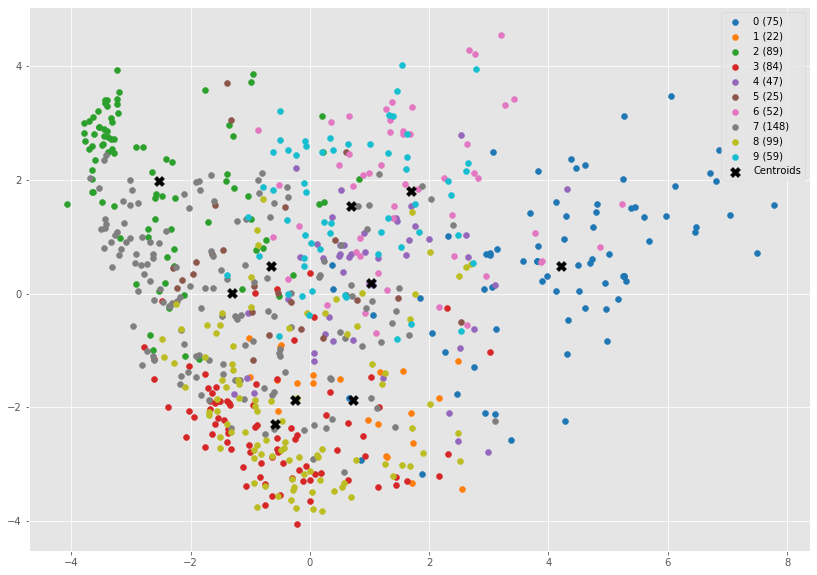

In [16]:
k_means = KMeansClustering(k=10, max_iterations=500)
k_means.fit(X)

plt.figure(figsize=(14, 10))

for (cluster, data), color in zip(k_means.classes.items(), colors):
    data = pca.transform(data)
    data = list(map(list, zip(*data)))
    plt.scatter(data[0], data[1], c=color, label=f'{cluster} ({len(data[0])})')

centroids = pca.transform(list(k_means.centroids.values()))
centroids = list(map(list, zip(*centroids)))

plt.scatter(centroids[0], centroids[1], marker='X', c='k', s=100, label='Centroids')

plt.legend()
plt.show()

In [10]:
X_pred = []
Y_pred = []
for cluster, data in k_means.classes.items():
    X_pred.extend(data)
    Y_pred.extend([cluster] * len(data))

new_X_pred = []
new_Y_pred = []
    
for real_pic, real_class in zip(X, Y):
    for pic, cluster in zip(X_pred, Y_pred):
        if np.array_equal(pic, real_pic):
            new_X_pred.append(pic)
            new_Y_pred.append(cluster)
            break

In [15]:
def cluster_rand(classes, clusters):
    tp, tn, fp, fn = 0, 0, 0, 0
    for pair1 in zip(classes, clusters):
        for pair2 in zip(classes, clusters):
            tp += 1 if pair1[0] == pair2[0] and pair1[1] == pair2[1] else 0
            tn += 1 if pair1[0] != pair2[0] and pair1[1] == pair2[1] else 0
            fp += 1 if pair1[0] == pair2[0] and pair1[1] != pair2[1] else 0
            fn += 1 if pair1[0] != pair2[0] and pair1[1] != pair2[1] else 0
    return (tp + fn) / (tp + tn + fp + fn)

outer_metric = cluster_rand(Y, new_Y_pred)
print(f'Rand index = {outer_metric:.2%}')
        

Rand index = 83.93%
